In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import os

# Create directory if it doesn't exist 
os.makedirs('../data/processed', exist_ok=True)

# Load the merged data from EDA [cite: 123]
df = pd.read_csv('../data/processed/fraud_data_with_geo.csv')

# 1. Data Cleaning 
df.drop_duplicates(inplace=True)
# Fill missing country values with 'Unknown' to maintain data integrity [cite: 114]
df['country'] = df['country'].fillna('Unknown')
df = df.fillna(0) 

print(f"Data loaded: {df.shape[0]} rows. Missing values handled.")

Data loaded: 151112 rows. Missing values handled.


In [8]:
# Correct data types for timestamps [cite: 116]
df['signup_time'] = pd.to_datetime(df['signup_time'])
df['purchase_time'] = pd.to_datetime(df['purchase_time'])

# 1. Time-based features [cite: 127-130]
df['hour_of_day'] = df['purchase_time'].dt.hour
df['day_of_week'] = df['purchase_time'].dt.dayofweek
df['time_since_signup'] = (df['purchase_time'] - df['signup_time']).dt.total_seconds()

# 2. Transaction frequency/velocity [cite: 126]
# Frequency per device and per IP address
df['device_freq'] = df.groupby('device_id')['device_id'].transform('count')
df['ip_freq'] = df.groupby('ip_address')['ip_address'].transform('count')

print("Feature engineering complete: Time-based and Velocity features added.")

Feature engineering complete: Time-based and Velocity features added.


In [9]:
# 3. Categorical Encoding (One-Hot Encoding) [cite: 133]
# Including 'country' is vital for geolocation analysis [cite: 124]
df_final = pd.get_dummies(df, columns=['source', 'browser', 'sex', 'country'], drop_first=True)

# 4. Scaling Numerical Features 
scaler = StandardScaler()
cols_to_scale = ['purchase_value', 'age', 'time_since_signup', 'device_freq', 'ip_freq']
df_final[cols_to_scale] = scaler.fit_transform(df_final[cols_to_scale])

print("Data transformation complete: Categorical columns encoded and numeric features scaled.")

Data transformation complete: Categorical columns encoded and numeric features scaled.


In [10]:
# Define features (X) and target (y) [cite: 143, 145]
X = df_final.drop(['class', 'user_id', 'device_id', 'signup_time', 'purchase_time', 'ip_address'], axis=1)
y = df_final['class']

# 1. Stratified Train-Test Split [cite: 142]
# We split first so that the test set remains "unseen" and realistic
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. Handle Class Imbalance with SMOTE (On Training Data Only) 
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Document the class distribution [cite: 137]
print("--- Class Distribution Documentation ---")
print(f"Before SMOTE (Train): {y_train.value_counts().to_dict()}")
print(f"After SMOTE (Train): {pd.Series(y_train_resampled).value_counts().to_dict()}")
print(f"Test Set (Original Ratio): {y_test.value_counts().to_dict()}")

--- Class Distribution Documentation ---
Before SMOTE (Train): {0: 109568, 1: 11321}
After SMOTE (Train): {0: 109568, 1: 109568}
Test Set (Original Ratio): {0: 27393, 1: 2830}


In [11]:
# Save the engineered features and target for Task 2 [cite: 138-158]
X_train_resampled.to_csv('../data/processed/X_train_final.csv', index=False)
y_train_resampled.to_csv('../data/processed/y_train_final.csv', index=False)
X_test.to_csv('../data/processed/X_test_final.csv', index=False)
y_test.to_csv('../data/processed/y_test_final.csv', index=False)

print("Task 1 Complete! Training and Test sets are ready for Task 2.")

Task 1 Complete! Training and Test sets are ready for Task 2.


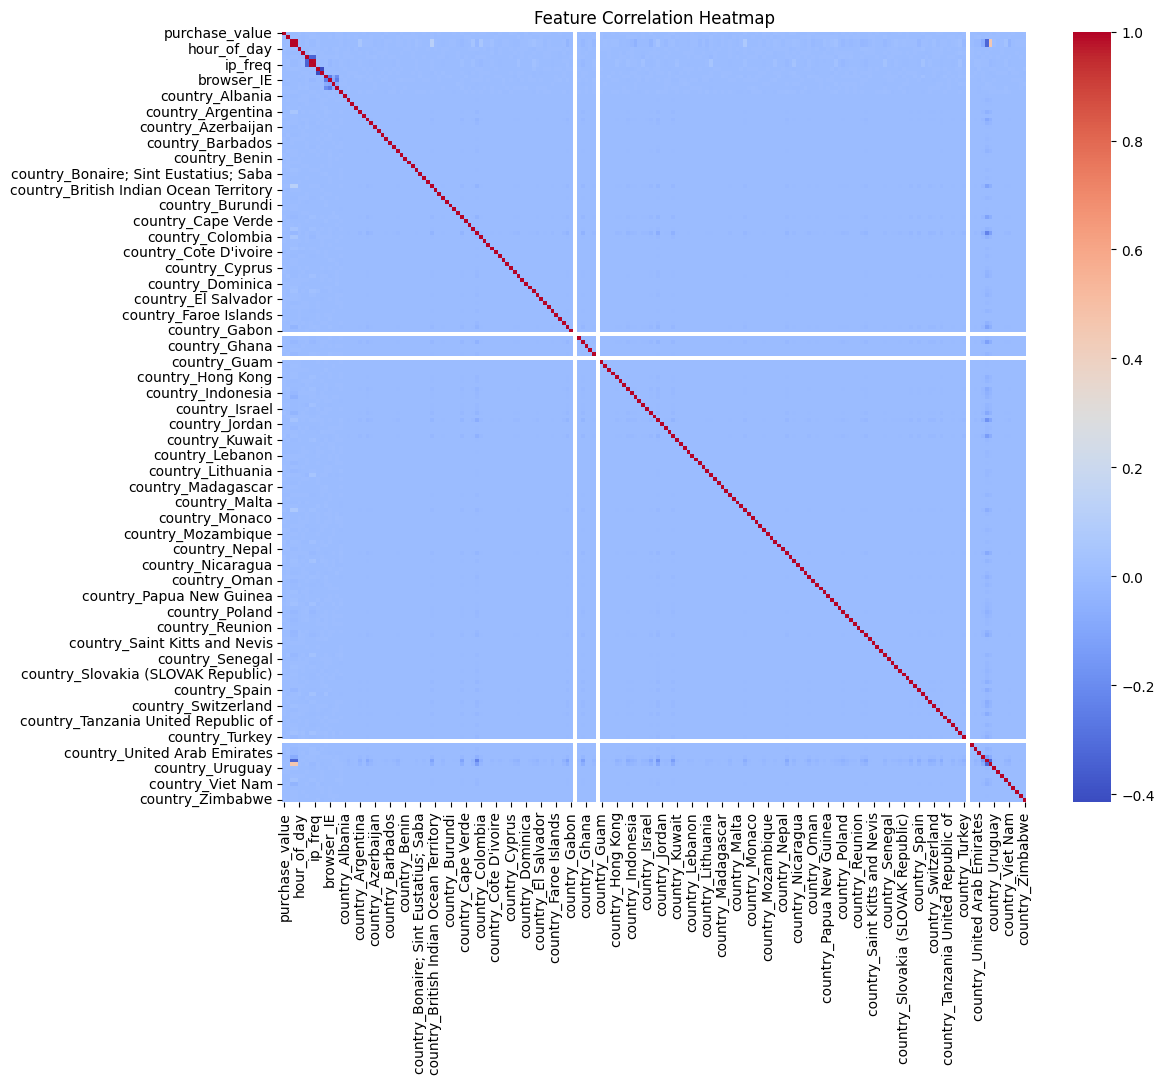

In [12]:
plt.figure(figsize=(12, 10))
sns.heatmap(X_train.corr(), annot=False, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()